<h1><center> Study: ER and NR Discrimination </center></h1>

Last Modified: By Daniel Baur on 13th May 2020

This jupyter notebook is used to conduct the ER and NR discrimination study utilizing NESTv2.1.

### Table of Contents


0. **[Stuff](#0.-Stuff)**<br>
    0.1 [Imports](#0.1-Imports)<br>
    0.2 [Definitions](#0.2-Definitions)<br>


1. **[Detector Parameter Space](#1.-Detector-Parameter-Space)**<br>
    1.0 [Definitions](#1.0-Definitions)<br>
    1.1 [Default Parameters](#1.2-Default-Parameters)<br>
    1.2 [Parameter Sweep](#1.2-Parameter-Sweep)<br>
    1.3 [Printing Parameter Values](#1.3-Printing-Parameter-Values)<br>
    1.4 [Generating Detector Files](#1.4-Generating-Detector-Files)<br>
    1.5 [Determining the Spectra Boundaries](1.5-Determining-the-Spectra-Boundaries)<br>


2. **[Input Spectra](#2.-Input-Spectra)**<br>
    2.0 [General Definitions](#2.0-General-Definitions)<br>
    2.1 [ER Background](#2.1-ER-Background)<br>
    2.2 [WIMPs](#2.2-WIMPs)<br>


3. **[Generating Data](#3.-Data-Generation)**<br>


4. **[Analysis](#4.-Analysis)**<br>
    4.0 [Investigations in Advance](#4.0-Investigations-in-Advance)<br>
    4.1 [Looping over Populations](#4.1-Looping-over-Populations)<br>



# 0. Stuff

## 0.1 Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('file://' +"/home/daniel/Desktop/arbeitsstuff/20180705__monxe/monxe_software/miscfig/danielsmplstyle.mplstyle")
import numpy as np
from scipy import stats
from scipy.special import binom as binomcoeff
from scipy.optimize import curve_fit
from scipy.integrate import quad
import datetime
import pprint
import itertools
import math
import os
from matplotlib.ticker import AutoMinorLocator
import subprocess
import json

# including the SFS libraries
import sys
sys.path.append("./../../") 
import SF
import SF_spectrum
import SF_detector
import SF_process
import SF_nestcom

## 0.2 Definitions

In [2]:

# formatting
uni_blue = '#004A9B'
uni_red = '#C1002A'
color_ers = uni_red
color_nrs = uni_blue

# paths
path_data = "./data/"
path_signatures = path_data +"signatures/"
path_popdata = path_data +"popdata/"
path_input = "./input/"
path_output = "./output/"
path_output_presentationstuff = path_output +"presentationstuff/"
path_spectra = path_data +"spectra/"
path_detectors = path_data +"detectors/"
path_presentation = "/home/daniel/Desktop/arbeitsstuff/20200420__conferences_workshops_excursions/20200909__darwin_collaboration_meeting_2020/talk_sfs/images/"
name_simdata = "simdata"
name_summarized_data = "summarized_data"
name_presentation = "presentation"
name_complot = "complot"


### flags
flag_delete_data = True
# detectors and spectra
flag_generate_detectors = True
flag_print_detector_parameters_texhtml = False
flag_test_spectrum_boundaries = False
flag_generate_erbkg_recoil_spectra = True
flag_generate_wimp_recoil_spectra = True
flag_plot_wimp_recoil_spectra = False
flag_plot_spectra = False
# raw data generation
flag_generate_raw_data = True
# analysis
flag_analysis_loop = False
flag_analysis_comparative = False


### flags
flag_delete_data = False
# detectors and spectra
flag_generate_detectors = False
flag_print_detector_parameters_texhtml = False
flag_test_spectrum_boundaries = False
flag_generate_erbkg_recoil_spectra = False
flag_generate_wimp_recoil_spectra = False
flag_plot_wimp_recoil_spectra = False
flag_plot_spectra = False
# raw data generation
flag_generate_raw_data = False
# analysis
flag_analysis_loop = False
flag_analysis_comparative = False


## 0.3 Preparations

In [3]:
if flag_delete_data == True:
    subprocess.call("rm -r ./data/spectra/*", shell=True)
    subprocess.call("rm -r ./data/detectors/*", shell=True)
    subprocess.call("rm -r ./data/signatures/*", shell=True)
    subprocess.call("rm -r ./data/popdata/*", shell=True)


# 1. Detector Parameter Space

## 1.0 Definitions

In [4]:
detector_filename = ""

paramrange_edrift = [100, 200, 500, 1000, 2000, 5000] # in V/cm
paramrange_edrift = [200] # in V/cm


## 1.1 Default Parameters

Within this cell the default detector parameters are defined. If one of the detector parameters is not specified during the simulation the default parameter defined below is used.

In [5]:

# default dictionary
default_detector_parameters = {
    "g1" : 0.119, # phd per S1 phot at dtCntr (not phe). Divide out 2-PE effect
    "sPEres" : 0.38, # single phe resolution (Gaussian assumed)
    "sPEthr" : 0.35, # POD threshold in phe, usually used IN PLACE of sPEeff
    "sPEeff" : 0.90, # actual efficiency, can be used in lieu of POD threshold
    "noise_0_" : 0.0, # baseline noise mean and width in PE (Gaussian)
    "noise_1_" : 0.0, # baseline noise mean and width in PE (Gaussian)
    "P_dphe" : 0.22, # chance 1 photon makes 2 phe instead of 1 in Hamamatsu PMT
    "coinWind" : 100, # S1 coincidence window in ns
    "coinLevel" : 3, # how many PMTs have to fire for an S1 to count
    "numPMTs" : 494, # For coincidence calculation
    # Linear noise" terms as defined in Dahl thesis and by D. McK
    "noise_2_" : 3e-2, # S1 -> S1 Gaussian-smeared with noise[2]*S1
    "noise_3_" : 3e-2, # S2 -> S2 Gaussian-smeared with noise[3]*S2
    # Ionization and Secondary Scintillation (S2) parameters
    "g1_gas" : 0.102, # phd per S2 photon in gas, used to get SE size
    "s2Fano" : 3.61, # Fano-like fudge factor for SE width
    "s2_thr" : 100., # the S2 threshold in phe or PE, *not* phd. Affects NR most
    "E_gas" : 10.85, # field in kV/cm between liquid/gas border and anode
    "eLife_us" : 1600., # the drift electron mean lifetime in micro-seconds
    # Thermodynamic Properties  [if you are getting warnings about being in gas, lower T and/or raise p]
    "inGas" : False, # 
    "T_Kelvin" : 175, # for liquid drift speed calculation
    "p_bar" : 2., # gas pressure in units of bars, it controls S2 size
    # Data Analysis Parameters and Geometry
    "dtCntr" : 822., # center of detector for S1 corrections, in usec.
    "dt_min" : 75.8, # minimum. Top of detector fiducial volume
    "dt_max" : 1536.5, # maximum. Bottom of detector fiducial volume
    "radius" : 1300., # millimeters (fiducial rad)
    "radmax" : 1350., # actual physical geo. limit
    "TopDrift" : 3005., # mm not cm or us (but, this *is* where dt=0), a z-axis value of 0 means the bottom of the detector (cathode OR bottom PMTs), In 2-phase, TopDrift=liquid/gas border. In gas detector it's GATE, not anode!
    "anode" : 3012.5, # the level of the anode grid-wire plane in mm, In a gas TPC, this is not TopDrift (top of drift region), but a few mm, above it
    "gate" : 3000., # mm. This is where the E-field changes (higher), in gas detectors, the gate is still the gate, but it's where S2 starts
    "cathode" : 250, # mm. Defines point below which events are gamma-X
    # 2-D (X & Y) Position Reconstruction
    "PosResExp" : 0.015, # exp increase in pos recon res at hi r, 1/mm
    "PosResBase" : 30., # baseline unc in mm, see NEST.cpp for usage
}


## 1.2 Parameter Sweep

Within the cell below the detector parameter deviating from the default detector parameters are specified. Each parameter name corresponds to a key in the ``darwin_detector_paramter_space`` dictionary. The corresponding key is a list containing the parameter value(s). If more than one parameter is given then the list is swept over.


import numpy as np


def calc_drift_time_in_us(
#    life_time_us, # electron life time in micro seconds
    drift_field_vpcm, # electrical drift field in volts per centimeters
    tpc_length_mm # tpc length, i.e. z dimension, in millimeters
):
    v_d = 0.71*(drift_field_vpcm*1)**0.15 # drift velocity in millimeters per microsecond
    #t_d = (tpc_length_mm) / v_d # drift time in microseconds
    return v_d


drift_field_list = [100, 200, 500, 1000, 2000, 5000]


for i in range(len(drift_field_list)):
    print(drift_field_list[i], "--->", calc_drift_time_in_us(drift_field_vpcm=drift_field_list[i], tpc_length_mm=3000))



In [6]:
# parameter space dictionary
darwin_detector_parameter_space = {
    #"g1" : [0.12, 0.25],
    "g1" : [0.16],
    #"eLife_us" : [500, 1000, 5000, 10000], # v_d = 0.71*E**0.15
    "eLife_us" : [1300], # v_d = 0.71*E**0.15
}


## 1.3 OPTIONAL: Printing Parameter Values

This cell is meant to generate LaTeX or html formatted output resembling the ``default_detector_parameters`` dictionary defined above. This output can then be used for the corresponding Wiki note or a LaTeX beamer slide. 

In [7]:
if flag_print_detector_parameters_texhtml == True:
    
    input_string_default = """
    "g1" : 0.119, # phd per S1 phot at dtCntr (not phe). Divide out 2-PE effect
    "sPEres" : 0.38, # single phe resolution (Gaussian assumed)
    "sPEthr" : 0.35, # POD threshold in phe, usually used IN PLACE of sPEeff
    "sPEeff" : 0.90, # actual efficiency, can be used in lieu of POD threshold
    "noise_0_" : 0.0, # baseline noise mean and width in PE (Gaussian)
    "noise_1_" : 0.0, # baseline noise mean and width in PE (Gaussian)
    "P_dphe" : 0.22, # chance 1 photon makes 2 phe instead of 1 in Hamamatsu PMT
    "coinWind" : 100, # S1 coincidence window in ns
    "coinLevel" : 3, # how many PMTs have to fire for an S1 to count
    "numPMTs" : 494, # For coincidence calculation
    # Linear noise" terms as defined in Dahl thesis and by D. McK
    "noise_2_" : 3e-2, # S1 -> S1 Gaussian-smeared with noise[2]*S1
    "noise_3_" : 3e-2, # S2 -> S2 Gaussian-smeared with noise[3]*S2
    # Ionization and Secondary Scintillation (S2) parameters
    "g1_gas" : 0.102, # phd per S2 photon in gas, used to get SE size
    "s2Fano" : 3.61, # Fano-like fudge factor for SE width
    "s2_thr" : 100., # the S2 threshold in phe or PE, *not* phd. Affects NR most
    "E_gas" : 10.85, # field in kV/cm between liquid/gas border and anode
    "eLife_us" : 1600., # the drift electron mean lifetime in micro-seconds
    # Thermodynamic Properties  [if you are getting warnings about being in gas, lower T and/or raise p]
    "inGas" : False, # 
    "T_Kelvin" : 175, # for liquid drift speed calculation
    "p_bar" : 2., # gas pressure in units of bars, it controls S2 size
    # Data Analysis Parameters and Geometry
    "dtCntr" : 822., # center of detector for S1 corrections, in usec.
    "dt_min" : 75.8, # minimum. Top of detector fiducial volume
    "dt_max" : 1536.5, # maximum. Bottom of detector fiducial volume
    "radius" : 1300., # millimeters (fiducial rad)
    "radmax" : 1350., # actual physical geo. limit
    "TopDrift" : 3005., # mm not cm or us (but, this *is* where dt=0), a z-axis value of 0 means the bottom of the detector (cathode OR bottom PMTs), In 2-phase, TopDrift=liquid/gas border. In gas detector it's GATE, not anode!
    "anode" : 3012.5, # the level of the anode grid-wire plane in mm, In a gas TPC, this is not TopDrift (top of drift region), but a few mm, above it
    "gate" : 3000., # mm. This is where the E-field changes (higher), in gas detectors, the gate is still the gate, but it's where S2 starts
    "cathode" : 250, # mm. Defines point below which events are gamma-X
    # 2-D (X & Y) Position Reconstruction
    "PosResExp" : 0.015, # exp increase in pos recon res at hi r, 1/mm
    "PosResBase" : 30., # baseline unc in mm, see NEST.cpp for usage
    """
    
    input_string_sweep = """
    "g1" : [0.11, 0.25], #[0.11, 0.13, 0.15, 0.17],
    "eLife_us" : [500, 1000, 2000], #[1500, 1750, 2000, 2250], # 
    """
    
    print("default detector parameters, html:")
    SF_detector.print_detector_parameters(input_string=input_string_default, input_string_format="default_parameters", output_format="html")
    print("\n")
    print("sweep parameters, html:")
    SF_detector.print_detector_parameters(input_string=input_string_sweep, input_string_format="parameter_sweep", output_format="html")
    print("\n")


## 1.4 Generating Detector Files

Within this cell the cartesian product of the utilized parameter space is calculated.

``parameter_sweep_dictionaries``:<br>The keys of this dictionary is a string which contains the deviations from the default detector parameters and the corresponding value is another dictionary containing the whole detector parameters. This dictionary is being looped over when the signature data is being generated:<br>
  (key,val) = (`string_with_deviations_from_default_detector`, `dictionary_with_all_detector_parameters`)

In [8]:
parameter_sweep_dictionaries = {} # this dictionary will contain all detector settings


# computing the cartesion product of the detector parameter space
cartesian_list = {} # from this list the 'update_dicts' will be generated
ctr = 0
for key in darwin_detector_parameter_space.keys():
    cartesian_list.update({key:[]})
    for i in range(len(darwin_detector_parameter_space[key])):
        cartesian_list[key].append([key, darwin_detector_parameter_space[key][i]])
        ctr += 1
parameters_cartesian_product = list(itertools.product(*cartesian_list.values()))


# generating one dictionary containing all the detector parameters including the 
for i in range(len(parameters_cartesian_product)):
    update_param_dict = {parameters_cartesian_product[i][j][0]:parameters_cartesian_product[i][j][1] for j in range(len(parameters_cartesian_product[i]))}
    dictname = ""
    for key in sorted([*update_param_dict]):
        dictname = dictname +key +"_" +SF_detector.numberstring(number_int_float_or_string=update_param_dict[key]) +"_"
    if dictname.endswith("_") :
        dictname = dictname[:-1]
    #update_param_dict = default_detector_parameters.copy().update(**update_param_dict)
    update_param_dict_full = default_detector_parameters.copy()
    update_param_dict_full.update(**update_param_dict)
    parameter_sweep_dictionaries.update({dictname: update_param_dict_full})


# printing the various detector parameter dictionaries that 
flag_print_parameter_sweep_dictionaries = True
if flag_print_parameter_sweep_dictionaries == True:
    for key, val in parameter_sweep_dictionaries.items():
        print(key)
        for k, v in parameter_sweep_dictionaries[key].items():
            print("   ", k, ": ", parameter_sweep_dictionaries[key][k])
        print("")


eLife_us_1300_g1_0_16
    g1 :  0.16
    sPEres :  0.38
    sPEthr :  0.35
    sPEeff :  0.9
    noise_0_ :  0.0
    noise_1_ :  0.0
    P_dphe :  0.22
    coinWind :  100
    coinLevel :  3
    numPMTs :  494
    noise_2_ :  0.03
    noise_3_ :  0.03
    g1_gas :  0.102
    s2Fano :  3.61
    s2_thr :  100.0
    E_gas :  10.85
    eLife_us :  1300
    inGas :  False
    T_Kelvin :  175
    p_bar :  2.0
    dtCntr :  822.0
    dt_min :  75.8
    dt_max :  1536.5
    radius :  1300.0
    radmax :  1350.0
    TopDrift :  3005.0
    anode :  3012.5
    gate :  3000.0
    cathode :  250
    PosResExp :  0.015
    PosResBase :  30.0



Within this cell one separate detector header file for each element of the cartesian product is generated.

In [9]:

# looping over all detector configurations
for key, val in parameter_sweep_dictionaries.items():

    # generating the detector header file with the current parameters
    SF_detector.gen_detector_hh_file_from_dict(
        detectorname=detector_filename +key,
        savefolders = ["./data/detectors/"],
        **parameter_sweep_dictionaries[key]
    )



SF_detector: generating eLife_us_1300_g1_0_16.hh.
SF_detector: reading /home/daniel/Desktop/arbeitsstuff/20180706__sfs/NEST4/install/../nest/include/Detectors/DetectorExample_XENON10.hh
SF_detector: modifying the template .hh file.
SF_detector: saved ./data/detectors/eLife_us_1300_g1_0_16.hh


## 1.5 OPTIONAL: Determining the Spectra Boundaries

This cell is used to calculate the boundaries (i.e. the maximum recoil energies) for the ER and NR spectra. Hereby it has to be ensured that the maximum NR energy of interest (i.e. ~40keV) yields an S1 that still lies within the examined observable space and that truncating this observable space does not affect the shape of the signatures within it.

In [10]:

if flag_test_spectrum_boundaries == True:
    
    test_spectrum_boundaries_name = "test_spectrum_boundaries"
    test_spectrum_boundaries_g1 = 0.17
    test_spectrum_boundaries_edepmax = 60 # 16
    test_spectrum_boundaries_it = "NR" # "ER"

    # generating the spectrum
    SF_spectrum.gen_gnampfino_parametersweep(
        name = test_spectrum_boundaries_name,
        savefolder = path_spectra,
        number_of_samples_per_run = 10000,
        paramrange_interactiontype = [test_spectrum_boundaries_it],
        paramrange_energydeposition = [test_spectrum_boundaries_edepmax],
        paramrange_edrift = [200]
    )

    # running NEST generating the data
    SF_nestcom.SF_nestcom_runnest(
        filestring_spectrum = path_spectra +test_spectrum_boundaries_name +".npy",
        pathstring_output = path_signatures,
        detectorname = "dummydetector",
        output_pre_string = "test_spectrum_simdata"
    )

    # processing the raw data
    test_spectrum_boundaries_processed_data = SF_process.gen_summarized_ndarray(
        input_folder = path_signatures,
        ndarray = "test_spectrum_simdata__" +test_spectrum_boundaries_name +"__dummydetector.npy",
        output_folder = path_output
    )

    print(f"mean cS1/g1 (e_dep={test_spectrum_boundaries_edepmax}keV_{test_spectrum_boundaries_it}): {test_spectrum_boundaries_processed_data['mean_s1_phe']/test_spectrum_boundaries_g1}")
    print(f"with 1sigma spread: {test_spectrum_boundaries_processed_data['mean_s1_phe_sigma']/test_spectrum_boundaries_g1}")

Running the above simulation for a maximum ER energy of ~16keV_ee and a maximum NR energy of ~60keV_nr yields a cS1/g1 value of ~730 which lies well beyond the mean cS1/g1 value of 450 corresponding to the maximum NR of interest energy of ~40keV.<br>
(Note that the used value for g1 is read out from the NEST output written to the terminal.)<br>
Accordingly I set the ER and NR energy ranges to [0,16] keV_ee and [0,60] keV_nr respectively.

# 2. Input Spectra

## 2.0 Definitions

Within this cell the parameters for the input ER and NR spectra are defined.

In [11]:

# simulation properties
number_of_events_per_population = 1000000 # this is the (approximate) number of particles per spectrum file


# ER background
filename_er_spectrum = f"erbkg_edrift_"
recoilenergyrange_er = [0,16]
numberofbins_er = 64
interactiontype_er = "beta"
er_binwidth = (recoilenergyrange_er[1] -recoilenergyrange_er[0])/numberofbins_er
paramrange_energydeposition_er = np.linspace(num=numberofbins_er, start=recoilenergyrange_er[0]+(0.5*er_binwidth), stop=recoilenergyrange_er[1]-(0.5*er_binwidth), endpoint=True)


# WIMPs
filename_nr_spectrum = f"wimps_edrift_"
recoilenergyrange_nr = [0,60]
numberofbins_nr = 60
interactiontype_nr = "NR"
# paramrange_energydeposition_nr is defined along with the histogram calculation
# WIMP simulation properties
wimpmass = 50 # in GeV
wimpcrosssection = 10**(-47) #1e-47 # in cm^2
activetargetmass = 40 # in tonnes, just relevant for the plots
exposuretime = 5 # in years, just relevant for the plots


## 2.1 ER Background

Within this cell the ER background recoil spectra are defined.

In [12]:

if flag_generate_erbkg_recoil_spectra == True:

    # looping over the 'edirft' parameterspace and generating both er background and wimp recoil spectra
    for i in range(len(paramrange_edrift)):

        # generating the spectrum from the data defined above
        SF_spectrum.gen_gnampfino_parametersweep(
            name = filename_er_spectrum +str(paramrange_edrift[i]),
            savefolder="./data/spectra/",
            number_of_samples_per_run = int(number_of_events_per_population/len(paramrange_energydeposition_er)),
            paramrange_interactiontype = [interactiontype_er],
            paramrange_energydeposition = paramrange_energydeposition_er,
            paramrange_edrift = [paramrange_edrift[i]]
        )


SF_spectrum: saved ndarray 'erbkg_edrift_200.npy' to './data/spectra/'


## 2.2 WIMPs

Within this cell the input WIMP recoil spectra are generated.

In [13]:

if flag_generate_wimp_recoil_spectra == True:

    # calculating the WIMP recoil spectrum
    paramrange_energydeposition_nr, abs_wimp_recoil_list = SF_spectrum.wimp_recoil_spectrum_for_composite_detector_material(
        mass_wimp_gev = wimpmass,
        cross_section_wimp_proton_cm2 = wimpcrosssection,
        mass_detector_target_t = activetargetmass,
        time_exposure_y = exposuretime,
        energy_threshold_kev = 0,
        energy_nuclear_recoil_min = recoilenergyrange_nr[0],
        energy_nuclear_recoil_max = recoilenergyrange_nr[1],
        number_of_bins_or_samples = numberofbins_nr,
        flag_output = "histogram"
    )

    # calculating the number of events per recoil energy bin
    wimp_recoil_rate_scale_factor = number_of_events_per_population/np.sum(abs_wimp_recoil_list) # making sure approximately the same number of WIMP recoils as ER background events is generated
    events_per_energy_bin_list = np.zeros_like(paramrange_energydeposition_nr)
    for i in range(len(events_per_energy_bin_list)):
        events_per_energy_bin_list[i] = int(abs_wimp_recoil_list[i]*wimp_recoil_rate_scale_factor)
        
    # looping over the 'edirft' parameterspace and generating the wimp recoil spectra
    for i in range(len(paramrange_edrift)):

        # summarize the spectrum data into a tuple list
        wimp_spectrum_tuple_list = []
        for j in range(len(paramrange_energydeposition_nr)):
            wimp_spectrum_tuple_list.append((events_per_energy_bin_list[j], interactiontype_nr, paramrange_energydeposition_nr[j], paramrange_edrift[i], "-1"))

        # generating and saving the wimp recoil spectrum from the tuple list defined above
        wimprecoilspectrum = SF_spectrum.gen_spectrum_ndarray_from_tuplelist(spectrum_tuple_list=wimp_spectrum_tuple_list)
        np.save("./data/spectra/" +filename_nr_spectrum +f"{str(int(paramrange_edrift[i]))}" +".npy", wimprecoilspectrum)


SF_spectrum.wimp_recoil_spectrum_for_composite_detector_material: your relative abundances add up to 100.0 %


## 2.3 Spectra Plotting

absolute ER background rate spectrum

In [14]:
    
if flag_plot_spectra == True:

    data = np.load("./data/spectra/" +filename_er_spectrum +str(paramrange_edrift[0]) +".npy")
    e_er_bin_centers_list_stepized, abs_er_rate_list_stepized = SF_process.stepize_histogram_data(bincenters=data["energy_deposition"], counts=data["number_of_events"])

    # setting up the canvas
    #fig, ax1 =plt.subplots(figsize=(5.670, 3.189), dpi=150)
    fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
    #plt.yscale("log")
    y_lim = [0, 1.2*max(data["number_of_events"])]
    ax1.set_xlim(recoilenergyrange_er)
    ax1.set_ylim(y_lim)
    plt.xlabel(r"ER Energy $[\mathrm{keV}_{\mathrm{ee}}]$")
    plt.ylabel(r"Integrated Recoil Rate $[\frac{\mathrm{events}}{" +f"{er_binwidth:.1f}"+"\,\mathrm{keV}_{\mathrm{nr}}}]$")
    #plt.title(r"WIMP recoil spectrum ($m_{\chi}="+ f"{m_chi}" +"\,\mathrm{GeV},\,\sigma_{\chi,p}^{\mathrm{SI}}=" +f"{sigma}" +"\,\mathrm{cm^2}$)")

    # plotting
    plt.plot(e_er_bin_centers_list_stepized, abs_er_rate_list_stepized, color=uni_blue)
    plt.text(x=0.98, y=0.75, transform=ax1.transAxes, s=r"total: " +f"{sum(data['number_of_events'])}" +" events", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    #plt.legend()
    plt.show()
    fig.savefig(f"./output/input_recoil_spectrum__er_background_constant_absolute.png")


differential WIMP recoil spectrum in LXe_nat

In [15]:
    
if flag_plot_spectra == True:

    # generating data
    e_nr_list, diff_rate_list = SF_spectrum.wimp_recoil_spectrum_for_composite_detector_material(
        mass_wimp_gev = wimpmass,
        cross_section_wimp_proton_cm2 = wimpcrosssection,
        energy_threshold_kev = 0,
        energy_nuclear_recoil_min = recoilenergyrange_nr[0],
        energy_nuclear_recoil_max = recoilenergyrange_nr[1],
        number_of_bins_or_samples=500,
        flag_output = "rate"
    )

    # setting up the canvas
    #fig, ax1 =plt.subplots(figsize=(5.670, 3.189), dpi=150)
    fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
    plt.yscale("log")
    x_lim = recoilenergyrange_nr
    #y_lim = [1e-10, 1e-6]
    #y_lim = [min(diff_rate_list), 1.2*max(diff_rate_list)]
    ax1.set_xlim(x_lim)
    #ax1.set_ylim(y_lim)
    plt.xlabel(r"NR Energy $[\mathrm{keV}_{\mathrm{nr}}]$")
    plt.ylabel(r"Rate $[\frac{\mathrm{events}}{\mathrm{keV}_{\mathrm{nr}}\times\mathrm{d}\times\mathrm{kg}}]$")
    #plt.title(r"WIMP recoil spectrum ($m_{\chi}="+ f"{m_chi}" +"\,\mathrm{GeV},\,\sigma_{\chi,p}^{\mathrm{SI}}=" +f"{sigma}" +"\,\mathrm{cm^2}$)")


    # plotting
    plt.plot(e_nr_list, diff_rate_list, color=uni_blue)
    plt.text(x=0.98, y=0.75, transform=ax1.transAxes, s=r"$m_{\chi}=" +f"{wimpmass}" +r"\,\mathrm{GeV}$, " +r"$\sigma^{\mathrm{SI}}_{p,\chi}=" +f"{wimpcrosssection}" +r"\,\mathrm{cm^2}$", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    #plt.legend()
    plt.show()
    fig.savefig(f"./output/input_recoil_spectrum__differential_wimp_recoil_spectrum_in_xenon_nat.png")


combined er and nr recoil spectra

In [16]:
             
if flag_plot_wimp_recoil_spectra == True:

    # nr data
    data_nr = np.load("./data/spectra/" +filename_nr_spectrum +str(paramrange_edrift[0]) +".npy")
    e_nr_bin_centers_list_stepized, abs_nr_rate_list_stepized = SF_process.stepize_histogram_data(bincenters=data_nr["energy_deposition"], counts=data_nr["number_of_events"])
    e_nr_bin_centers_list_stepized = list(e_nr_bin_centers_list_stepized)
    abs_nr_rate_list_stepized = list(abs_nr_rate_list_stepized)
    noe_nr = 0.5*np.sum(abs_nr_rate_list_stepized)

    # er data
    data_er = np.load("./data/spectra/" +filename_er_spectrum +str(paramrange_edrift[0]) +".npy")
    e_er_bin_centers_list_stepized, abs_er_rate_list_stepized = SF_process.stepize_histogram_data(bincenters=data_er["energy_deposition"], counts=data_er["number_of_events"])
    e_er_bin_centers_list_stepized = list(e_er_bin_centers_list_stepized)
    abs_er_rate_list_stepized = list(abs_er_rate_list_stepized)
    noe_er = 0.5*np.sum(abs_er_rate_list_stepized)
    binwidth_er = e_er_bin_centers_list_stepized[2] -e_er_bin_centers_list_stepized[0]

    # setting up the canvas
    #fig, ax1 =plt.subplots(figsize=(5.670, 3.189), dpi=150)
    fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
    x_lim_list = [0,1.05*max(max(e_nr_bin_centers_list_stepized),max(e_er_bin_centers_list_stepized))]
    y_lim_list = [0,1.1*max(max(abs_nr_rate_list_stepized),max(abs_er_rate_list_stepized))]
    ax1.set_xlim(x_lim_list)
    ax1.set_ylim(y_lim_list)
    plt.xlabel(r"Recoil Energy $[\mathrm{keV}]$")
    plt.ylabel(r"Recoil Events $[\frac{\mathrm{events}}{\mathrm{energy\,\,bin}}]$")
    #plt.title(r"WIMP recoil spectrum ($m_{\chi}="+ f"{m_chi}" +"\,\mathrm{GeV},\,\sigma_{\chi,p}^{\mathrm{SI}}=" +f"{sigma}" +"\,\mathrm{cm^2}$)")

    ### plotting
    # vertical histogram lines
    for i in range(len(e_nr_bin_centers_list_stepized)):
        if (i==0) or (i%2==0):
            plt.plot([e_nr_bin_centers_list_stepized[i], e_nr_bin_centers_list_stepized[i]], [0, abs_nr_rate_list_stepized[i]], linewidth=0.3, color=color_nrs)
    for i in range(len(e_er_bin_centers_list_stepized)):
        if (i==0) or (i%2==0):
            plt.plot([e_er_bin_centers_list_stepized[i], e_er_bin_centers_list_stepized[i]], [0, abs_er_rate_list_stepized[i]], linewidth=0.3, color=color_ers)
    # histogram data
    #e_nr_bin_centers_list_stepized.append(e_nr_bin_centers_list_stepized[len(e_nr_bin_centers_list_stepized)-1])
    #abs_nr_rate_list_stepized.append(0)
    #e_er_bin_centers_list_stepized.append(e_er_bin_centers_list_stepized[len(e_er_bin_centers_list_stepized)-1])
    #abs_er_rate_list_stepized.append(0)
    e_er_bin_centers_list_stepized = [e_er_bin_centers_list_stepized[0]] +e_er_bin_centers_list_stepized +[e_er_bin_centers_list_stepized[len(e_er_bin_centers_list_stepized)-1]]
    abs_er_rate_list_stepized = [0] +abs_er_rate_list_stepized +[0]
    e_nr_bin_centers_list_stepized = [e_nr_bin_centers_list_stepized[0]] +e_nr_bin_centers_list_stepized +[e_nr_bin_centers_list_stepized[len(e_nr_bin_centers_list_stepized)-1]]
    abs_nr_rate_list_stepized = [0] +abs_nr_rate_list_stepized +[0]
    plt.plot(e_nr_bin_centers_list_stepized, abs_nr_rate_list_stepized, color=uni_blue)
    plt.plot(e_er_bin_centers_list_stepized, abs_er_rate_list_stepized, color=uni_red)
    # text
    plt.text(x=0.98, y=0.9, transform=ax1.transAxes, s=r"$m_{\chi}=" +f"{wimpmass}" +r"\,\mathrm{GeV}$, " +r"$\sigma^{\mathrm{SI}}_{p,\chi}=" +f"{SF_process.exponential_float_to_latex(expfloat=wimpcrosssection)}" +r"\,\mathrm{cm^2}$", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    plt.text(x=0.98, y=0.75, transform=ax1.transAxes, s=r"total: $\sim" +f"{number_of_events_per_population}" +"$ events per population", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    #plt.text(x=0.98, y=0.60, transform=ax1.transAxes, s=r"(flat ER background: $" +f"\sim {abs_er_rate_list_stepized[0]:.0f}" +r"\,\frac{\mathrm{events}}{" +f"{binwidth_er:.2f}" +r"\,\mathrm{keV}}$)", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    plt.text(x=0.25, y=0.40, transform=ax1.transAxes, s=r"WIMP recoils", color=uni_blue, fontsize=11, verticalalignment='bottom', horizontalalignment='left')
    plt.text(x=0.27, y=0.16, transform=ax1.transAxes, s=r"ER background recoils", color=uni_red, fontsize=11, verticalalignment='bottom', horizontalalignment='left')
    #plt.legend()
    plt.show()
    fig.savefig(path_output_presentationstuff +f"input_recoil_spectrum__er_and_nr_rates_absolute.png")
    fig.savefig(path_presentation +f"input_recoil_spectrum__er_and_nr_rates_absolute.png")


# 3. Generating Signature Data

Within this cell for every examined detector configuration (i.e. field strength plus detector parameter combination) the following steps are being executed:
* the current detector configuration is implemented
* the ER signature is being simulated using NEST
* the NR signature is being simulated using NEST
The signature data is then saved within the ``./data/signatures/`` folder.

In [17]:

if flag_generate_raw_data == True:

    savelist = []

    ### looping over all possible parameter combinations (edrift and detector parameters)
    for i in range(len(paramrange_edrift)):
        for key, val in parameter_sweep_dictionaries.items():


            # implementing the just generated detector header file into NEST
            SF_nestcom.SF_nestcom_implementdetector(
                filestring_detector = "./data/detectors/" +detector_filename +key +".hh"
            )

            # running NEST with the just adjusted detector and both the ER background and WIMP spectra
            SF_nestcom.SF_nestcom_runnest(
                filestring_spectrum = "./data/spectra/" +filename_er_spectrum +str(paramrange_edrift[i]) +".npy",
                pathstring_output = "./data/signatures/",
                detectorname = detector_filename +key,
                output_pre_string="simdata"
            )
            g2_extracted = SF_nestcom.SF_nestcom_runnest(
                filestring_spectrum = "./data/spectra/" +filename_nr_spectrum +str(paramrange_edrift[i]) +".npy",
                pathstring_output = "./data/signatures/",
                detectorname = detector_filename +key,
                output_pre_string="simdata"
            )
            
            # saving the extracted g2 value into 'parameter_sweep_dictionaries'
            parameter_sweep_dictionaries[key].update(
                {"g2_extracted" : g2_extracted}
            )
            print(key +" ---> extracted g2: " +str(g2_extracted))
            


#######################################
SF_nestcom_implementdetector: Initializing.
SF_nestcom_implementdetector: copied './data/detectors/eLife_us_1300_g1_0_16.hh' into '/home/daniel/Desktop/arbeitsstuff/20180706__sfs/NEST4/install/../nest/include/Detectors/'
SF_nestcom_implementdetector: reading in file '/home/daniel/Desktop/arbeitsstuff/20180706__sfs/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: modifying data of file '/home/daniel/Desktop/arbeitsstuff/20180706__sfs/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: editing file '/home/daniel/Desktop/arbeitsstuff/20180706__sfs/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: performing a clean re-install
SF_nestcom_implementdetector: performed 'make clean'
SF_nestcom_implementdetector: performed 'make'
SF_nestcom_implementdetector: performed 'make install'
#######################################
SF_nestcom_runnest: initializing.
SF_nestcom_runnest: running NEST via: $ t

./../../SF_nestcom.py:207: RuntimeWarning: invalid value encountered in log10
  np.float64(np.log10(np.float64(row[s2_column_id])/np.float64(row[s1_column_id])))


SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_200_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_200_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_200_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_200_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_200_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_200_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_200_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_200_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_200_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_200_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_200_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_200_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_200_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_200_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_200_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_200_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_200_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_200_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_200_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_200_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_200_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_200_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_200_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_200_0
SF_nestcom_runnest: generating simdata__erbkg_edrift_200__eLife_us_1300_g1_0_16.npy
SF_nestcom_runnest: generated concatenated array simdata__erbkg_edrift_200__eLife_us_1300_g1_0_16
SF_nestcom_runnest: saved concatenated array ./data/signatures/simdata__erbkg_edrift_200__eLife_us_1300_g1_0_16.npy
SF_nestcom_runnest: cleaned up ./temp/
#######################################
SF_nestcom_runnest: initializing.
SF_nestcom_runnest: running NEST via: $ testNEST <n_events> <ER_or_NR> <e_dep_min> <e_dep_max> <e_drift> <pos>
SF_nestcom_runnest: running EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_200_0
SF_nestcom_runnest: successfully ran EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_200_0
SF_nestcom_runnest: saved EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_200_0
SF_nestcom_runnest: running EVENTS_5576

SF_nestcom_runnest: successfully ran EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_200_0
SF_nestcom_runnest: saved EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_200_0
SF_nestcom_runnest: running EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_200_0
SF_nestcom_runnest: successfully ran EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_200_0
SF_nestcom_runnest: saved EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_200_0
SF_nestcom_runnest: running EVENTS_9283__INTERACTION_NR__ENERGY_31_5__EDRIFT_200_0
SF_nestcom_runnest: successfully ran EVENTS_9283__INTERACTION_NR__ENERGY_31_5__EDRIFT_200_0
SF_nestcom_runnest: saved EVENTS_9283__INTERACTION_NR__ENERGY_31_5__EDRIFT_200_0
SF_nestcom_runnest: running EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_200_0
SF_nestcom_runnest: successfully ran EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_200_0
SF_nestcom_runnest: saved EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_200_0
SF_nestcom_runnest: running EVENTS_8093__INTERACTION_NR__

# 4. Analysis

## 4.0 OPTIONAL: Investigations in Advance

The cell below is used to investigate the various populations popping up in the cS1/cS2 observable space and gain an understanding regarding their origin.<br>
Hereby a few unphysical populations were identified that correspond to negative (i.e. unphysical) cS1 and cS2 values.

In [18]:

flag_investigate_populations = False

if flag_investigate_populations == True:

    # defining the parameters (testing)
    param_dict = {
        "edrift" : 750,
        "g1" : 0.15,
        "eLife_us" : 2000
    }

    # loading data
    er_data = np.load(path_input +"simdata__erbkg_edrift_750__g1_0_15_eLife_us_2000.npy")
    nr_data = np.load(path_input +"simdata__wimps_edrift_750__g1_0_15_eLife_us_2000.npy")
    er_s1_over_g1 = np.divide(er_data["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1 = np.log10(np.divide(er_data["s2_phe"], er_data["s1_phe"]))
    nr_s1_over_g1 = np.divide(nr_data["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1 = np.log10(np.divide(nr_data["s2_phe"], nr_data["s1_phe"]))

    # strange data 1: cS1 == cS2 == -10**(-6)
    threshold_s1 = 0.1
    threshold_s2 = 0.1
    er_data_strange_1 = er_data[(er_data["s1_phe"] == -10**(-6)) & (er_data["s2_phe"] == -10**(-6))]
    nr_data_strange_1 = nr_data[(nr_data["s1_phe"] == -10**(-6)) & (nr_data["s2_phe"] == -10**(-6))]
    er_s1_over_g1_strange_1 = np.divide(er_data_strange_1["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1_strange_1 = np.log10(np.divide(er_data_strange_1["s2_phe"], er_data_strange_1["s1_phe"]))
    nr_s1_over_g1_strange_1 = np.divide(nr_data_strange_1["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1_strange_1 = np.log10(np.divide(nr_data_strange_1["s2_phe"], nr_data_strange_1["s1_phe"]))
    
    # strange data 2: cS1 == -10**(-6) != cS2
    er_data_strange_2 = er_data[(er_data["s1_phe"] == -10**(-6)) & (er_data["s2_phe"] <= 0) & (er_data["s2_phe"] != -10**(-6))]
    nr_data_strange_2 = nr_data[(nr_data["s1_phe"] == -10**(-6)) & (nr_data["s2_phe"] <= 0) & (nr_data["s2_phe"] != -10**(-6))]
    er_s1_over_g1_strange_2 = np.divide(er_data_strange_2["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1_strange_2 = np.log10(np.divide(er_data_strange_2["s2_phe"], er_data_strange_2["s1_phe"]))
    nr_s1_over_g1_strange_2 = np.divide(nr_data_strange_2["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1_strange_2 = np.log10(np.divide(nr_data_strange_2["s2_phe"], nr_data_strange_2["s1_phe"]))

    # strange data 3: cS1 =! -10**(-6) == cS2
    er_data_strange_3 = er_data[(er_data["s1_phe"] != -10**(-6)) & (er_data["s1_phe"] <= 0) & (er_data["s2_phe"] == -10**(-6))]
    nr_data_strange_3 = nr_data[(nr_data["s1_phe"] != -10**(-6)) & (nr_data["s1_phe"] <= 0) & (nr_data["s2_phe"] == -10**(-6))]
    er_s1_over_g1_strange_3 = np.divide(er_data_strange_3["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1_strange_3 = np.log10(np.divide(er_data_strange_3["s2_phe"], er_data_strange_3["s1_phe"]))
    nr_s1_over_g1_strange_3 = np.divide(nr_data_strange_3["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1_strange_3 = np.log10(np.divide(nr_data_strange_3["s2_phe"], nr_data_strange_3["s1_phe"]))

    # strange data 4: cS1 =! -10**(-6) != cS2
    er_data_strange_4 = er_data[(er_data["s1_phe"] != -10**(-6)) & (er_data["s1_phe"] <= 0) & (er_data["s2_phe"] != -10**(-6)) & (er_data["s2_phe"] <= 0)]
    nr_data_strange_4 = nr_data[(nr_data["s1_phe"] != -10**(-6)) & (nr_data["s1_phe"] <= 0) & (nr_data["s2_phe"] != -10**(-6)) & (nr_data["s2_phe"] <= 0)]
    er_s1_over_g1_strange_4 = np.divide(er_data_strange_4["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1_strange_4 = np.log10(np.divide(er_data_strange_4["s2_phe"], er_data_strange_4["s1_phe"]))
    nr_s1_over_g1_strange_4 = np.divide(nr_data_strange_4["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1_strange_4 = np.log10(np.divide(nr_data_strange_4["s2_phe"], nr_data_strange_4["s1_phe"]))

    # modified data
    er_data_mod = er_data[(er_data["s1_phe"] >= 0) & (er_data["s2_phe"] >= 0)]
    nr_data_mod = nr_data[(nr_data["s1_phe"] >= 0) & (nr_data["s2_phe"] >= 0)]
    er_s1_over_g1_mod = np.divide(er_data_mod["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1_mod = np.log10(np.divide(er_data_mod["s2_phe"], er_data_mod["s1_phe"]))
    nr_s1_over_g1_mod = np.divide(nr_data_mod["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1_mod = np.log10(np.divide(nr_data_mod["s2_phe"], nr_data_mod["s1_phe"]))
   
    # investigating strange populations
    print("strange populations:")
    print(er_data.dtype.names)
    threshold = 5
    investigation_data_er = er_data[(er_data["s1_phe"]<=threshold) & (er_data["s1_phe"]>=threshold) & (er_data["s2_phe"]<=threshold) & (er_data["s2_phe"]>=threshold)]
    for i in range(len(investigation_data_er)):
        print(investigation_data_er[i])

    ### plotting
    # formatting
    fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
    #ax1.set_xlim([0,500])
    #ax1.set_ylim([2,3.75])
    plt.xlabel(r"$\frac{cS1}{g_1}\,[\mathrm{PE}]$")
    plt.ylabel(r"$\mathrm{log}_{10}\left(\frac{cS2}{cS1}\right)$")
    # plotting data
    plt.text(x=0.45, y=0.70, s=r"ER Background", transform=ax1.transAxes, color=color_ers, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=er_s1_over_g1, y=er_log10_s2_over_s1, s=4, facecolor=color_ers, marker=".", alpha=0.45, linewidths=0, edgecolors=None)
    plt.text(x=0.45, y=0.55, s=r"WIMP NRs", transform=ax1.transAxes, color=color_nrs, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=nr_s1_over_g1, y=nr_log10_s2_over_s1, s=4, facecolor=color_nrs, marker=".", alpha=0.45, linewidths=0, edgecolors=None)
    color_strange_1 = "green"
    plt.text(x=0.07, y=0.44, s=r"$cS1 = cS2 = -10^{-6}$", transform=ax1.transAxes, color=color_strange_1, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=er_s1_over_g1_strange_1, y=er_log10_s2_over_s1_strange_1, s=4, facecolor=color_strange_1, marker=".", alpha=1, linewidths=0, edgecolors=None)
    plt.scatter(x=nr_s1_over_g1_strange_1, y=nr_log10_s2_over_s1_strange_1, s=4, facecolor=color_strange_1, marker=".", alpha=1, linewidths=0, edgecolors=None)
    color_strange_2 = "cyan"
    plt.text(x=0.07, y=0.91, s=r"$cS1 = -10^{-6} \neq cS2$", transform=ax1.transAxes, color=color_strange_2, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=er_s1_over_g1_strange_2, y=er_log10_s2_over_s1_strange_2, s=4, facecolor=color_strange_2, marker=".", alpha=1, linewidths=0, edgecolors=None)
    plt.scatter(x=nr_s1_over_g1_strange_2, y=nr_log10_s2_over_s1_strange_2, s=4, facecolor=color_strange_2, marker=".", alpha=1, linewidths=0, edgecolors=None)
    color_strange_3 = "orange"
    plt.text(x=0.07, y=0.11, s=r"$cS1 \neq -10^{-6} = cS2$", transform=ax1.transAxes, color=color_strange_3, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=er_s1_over_g1_strange_3, y=er_log10_s2_over_s1_strange_3, s=4, facecolor=color_strange_3, marker=".", alpha=1, linewidths=0, edgecolors=None)
    plt.scatter(x=nr_s1_over_g1_strange_3, y=nr_log10_s2_over_s1_strange_3, s=4, facecolor=color_strange_3, marker=".", alpha=1, linewidths=0, edgecolors=None)
    color_strange_4 = "purple"
    plt.text(x=0.07, y=0.57, s=r"$cS1 \neq -10^{-6} \neq cS2$", transform=ax1.transAxes, color=color_strange_4, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=er_s1_over_g1_strange_4, y=er_log10_s2_over_s1_strange_4, s=4, facecolor=color_strange_4, marker=".", alpha=1, linewidths=0, edgecolors=None)
    plt.scatter(x=nr_s1_over_g1_strange_4, y=nr_log10_s2_over_s1_strange_4, s=4, facecolor=color_strange_4, marker=".", alpha=1, linewidths=0, edgecolors=None)
    #plt.legend()
    # saving
    plt.show()
    savename = "investigating_strange_populations_"
    savestring = ""
    for key, val in param_dict.items():
        savestring = savestring +"_" +key +"_" +str(val).replace(".","_")
    fig.savefig(path_output_presentationstuff +name_presentation +"__" +savename +".png")
    fig.savefig(path_presentation +name_presentation +"__" +".png")


Conclusion:<br>
Apparently some events (preferrably lower energetic ones) yield negative and strange S1 and/or S2 signatures within NEST (probably due to threshold effects). If only either of the S1 and S2 values is negative, then the argument of 'np.log10' is negative and 'np.log10' evaluates to 'NaN'; those events are not plotted at all. If both S1 and S2 are negative, the the argument of 'np.log10' is positive again. Nevertheless these events are considered neglected. Furthermore '-10**(-6)' appears to be some relevant default return value. In the plot above the various discarded populations have been identified. In order to discard those events it is sufficient to just process events with S1 and S2 values greater than 0.

## 4.1 Poplots: Investigating Signature Data

For every detector configuration (i.e. drift field +NEST detector file) the corresponding signature data (i.e. ER background +WIMP spectrum) is examined. The data extracted from each of those detector configuration is then displayed within poplot and saved as a ndarray. 



In [19]:
# This function is used to draw an energy contour line onto a signature data plot in the log(cS2/cS1) vs. cS1/g1 observable space.
def draw_energy_contour_line(
    param_e_keV, # in keV
    param_g1,
    param_g2,
    param_w = SF.W,
    number_of_samples = 150,
    fmt_rel_annotation_height_y = 0.04,
    fmt_color = "#8c8c8b",
    fmt_linewidth = 0.8,
    fmt_fontsize = 7,
    fmt_x_offset = 0.01,
    flag_annotateenergyval = True):

    # general stuff
    param_e = param_e_keV *1000

    # calculating the data points to be plotted as countour line
    contour_tuplelist = []
    contour_dtype = np.dtype([
        ("s1", np.float64),
        ("s1_g1", np.float64),
        ("s2", np.float64),
        ("log_s2_s1", np.float64)])
    max_x_val = param_e/param_w
    for i in np.linspace(start=0, stop=max_x_val, num=number_of_samples, endpoint=True):
        s1 = i*param_g1
        s2 = param_g2*(max_x_val - i)
        appendtuple = (
            s1,
            i,
            s2,
            np.log10(s2/s1))
        if i != 0 and i != max_x_val:
            contour_tuplelist.append(appendtuple)
    contour_data = np.array(contour_tuplelist, contour_dtype)

    # plotting the contour line
    plt.plot(
        contour_data["s1_g1"],
        contour_data["log_s2_s1"],
        color = fmt_color,
        linewidth = fmt_linewidth)
    
    # annotating the energy value
    x_axis_limits = plt.gca().get_xlim() # retrieving the x-axis boundaries
    y_axis_limits = plt.gca().get_ylim() # retrieving the y-axis boundaries
    approximate_y_val = y_axis_limits[0] +fmt_rel_annotation_height_y*(y_axis_limits[1]-y_axis_limits[0]) # calculating a y-axis value that is corresponds to a fraction of 'fmt_rel_annotation_height' times the  whole y-axis scale
    best_y_val = [np.sqrt((contour_data["log_s2_s1"][i]-approximate_y_val)**2) for i in range(len(contour_data))] # determining the value from 'contour_data["log_s2_s1"]' that deviates the least from the one defined above
    min_dev_index = best_y_val.index(np.min(best_y_val)) # determining the index of the value defined above
    extracted_x_val = contour_data["s1_g1"][min_dev_index] # extract the corresponding x, i.e. 's1/g1', value
    fmt_rel_annotation_height_x = (extracted_x_val-x_axis_limits[0])/(x_axis_limits[1]-x_axis_limits[0]) # converting the absolute x value to a relative one
    if flag_annotateenergyval == True:
        plt.text(
            y = fmt_rel_annotation_height_y,
            x = fmt_rel_annotation_height_x +fmt_x_offset,
            transform = ax1.transAxes,
            s =  r"$" +f"{param_e_keV:.1f}" +r"\,\mathrm{keV_{ee}}$",
            color = fmt_color,
            fontsize = fmt_fontsize,
            verticalalignment = 'center',
            horizontalalignment = 'left')

    return



In [33]:
# This function is used to extract population data from input ER and NR signatures.
# I.e. the input signatures are sliced into bins (according to 'flag_slicing') and every subset of data is then analyzed in terms of leakage.
def get_popdata_from_signature_data(
    input_er_data,
    input_nr_data,
    bin_edges,
    threshold_events_per_bin = 20,
    nr_acceptances = [50, 85], # former: leakage_fraction_percentile
    savestring = "",
    flag_slicing = ["s1_g1", "er_ee"][1],
    flag_returnsubdatasets = True,
    **kwargs
):
    
    # definitions
    # bins
    bin_width = bin_edges[1] -bin_edges[0]
    bin_centers = [bin_edges[i] +0.5*(bin_edges[i+1] -bin_edges[i]) for i in range(len(bin_edges)-1)]
    # output data
    popdata_dtype = [
        ("bin_center", np.float64)]
    for i in range(len(nr_acceptances)):
        nracc_add_string = "nracc_" +f"{nr_acceptances[i]:.1f}".replace(".","_") +"__"
        popdata_dtype = popdata_dtype +[
            (nracc_add_string +"threshold_value", np.float64),
            (nracc_add_string +"discriminationline_x_left", np.float64),
            (nracc_add_string +"discriminationline_x_right", np.float64),
            (nracc_add_string +"n_nr_events_in_bin", np.uint64),
            (nracc_add_string +"n_er_events_in_bin", np.uint64),
            (nracc_add_string +"n_er_events_below_threshold", np.uint64),
            (nracc_add_string +"leakage_fraction_in_bin", np.float64),
            (nracc_add_string +"leakage_fraction_in_bin_error", np.float64)]
    popdata_tuple_list = []
    sliced_data_er = []
    sliced_data_nr = []

    # looping over the bins/slices to generate 'popdata' data and add it to the 'popdata_tuple_list'
    for j in range(len(bin_edges)-1):

        # selecting the data corresponding to the current bin/slice
        if flag_slicing == "er_ee":
            er_bin_data = input_er_data[
                (input_er_data["s2_phe"] >= ((kwargs["g2"]/kwargs["w"])*bin_edges[j]*1000) -((kwargs["g2"]/kwargs["g1"])*input_er_data["s1_phe"]) ) &
                (input_er_data["s2_phe"] <= ((kwargs["g2"]/kwargs["w"])*bin_edges[j+1]*1000) -((kwargs["g2"]/kwargs["g1"])*input_er_data["s1_phe"]))]
            nr_bin_data = input_nr_data[
                (input_nr_data["s2_phe"] >= ((kwargs["g2"]/kwargs["w"])*bin_edges[j]*1000) -((kwargs["g2"]/kwargs["g1"])*input_nr_data["s1_phe"]) ) &
                (input_nr_data["s2_phe"] <= ((kwargs["g2"]/kwargs["w"])*bin_edges[j+1]*1000) -((kwargs["g2"]/kwargs["g1"])*input_nr_data["s1_phe"]))]
        elif flag_slicing == "s1_g1": # this I still need to implement
            er_bin_data = input_er_data
            nr_bin_data = input_nr_data
        else:
            raise Exception("undefined 'flag_slicing'")
            
        # extracting data from to the current bin/slice
        n_nr = len(nr_bin_data) # <--- popdata: "n_nr_events_in_bin"
        n_er = len(er_bin_data) # <--- popdata: "n_er_events_in_bin"

        # checking whether there are sufficient events within the current bin/slice
        if (n_er > threshold_events_per_bin) and (n_nr > threshold_events_per_bin):

            # looping over all NR acceptances
            popdata_tuple = (bin_edges[j]+0.5*bin_width, )
            for k in range(len(nr_acceptances)):

                # calculating the leakage beneath the threshold
                percentile_index = int(len(nr_bin_data)*(nr_acceptances[k]/100)) # number of events for an NR acceptance of 'nr_acceptances[k]'
                percentile_threshold_value = sorted(list(nr_bin_data["log_s2_s1"]))[percentile_index] # 'log_s2_s1' value corresponding to the NR acceptance defined above
                n_er_below_threshold = len(er_bin_data[(er_bin_data["log_s2_s1"] <= percentile_threshold_value)]) # <--- popdata: "n_er_events_below_threshold"
                leakage_fraction_within_current_bin = n_er_below_threshold/n_er # <--- popdata: "leakage_fraction_in_bin"
                leakage_fraction_within_current_bin_error = np.sqrt(n_er_below_threshold)/n_er # <--- popdata: "leakage_fraction_in_bin_error"

                # calculating the x values of the discrimination line for the log_s2_s1 over s1_g1 observable space
                if flag_slicing == "er_ee":
                    c_star = 10**(percentile_threshold_value)
                    first_factor_low = (1/c_star) *(kwargs["g2"]/(kwargs["w"]*kwargs["g1"])) *bin_edges[j]*1000
                    first_factor_high = (1/c_star) *(kwargs["g2"]/(kwargs["w"]*kwargs["g1"])) *bin_edges[j+1]*1000
                    second_factor = 1/(1 +(1/c_star)*(kwargs["g2"]/kwargs["g1"]))
                    discrline_x_left = first_factor_low *second_factor
                    discrline_x_right = first_factor_high *second_factor
                elif flag_slicing == "s1_g1":
                    a = 3
                else:
                    raise Exception("invalid 'flag_slicing'")

                # adding data to the 'popdata_tuple'
                popdata_tuple = popdata_tuple +(
                    percentile_threshold_value,
                    discrline_x_left,
                    discrline_x_right,
                    n_nr,
                    n_er,
                    n_er_below_threshold,
                    leakage_fraction_within_current_bin,
                    leakage_fraction_within_current_bin_error)

            # adding data to the 'popdata_tuple_list'
            popdata_tuple_list.append(popdata_tuple)

        # saving the subdatasets
        if flag_returnsubdatasets == True:
            sliced_data_nr.append(nr_bin_data)
            sliced_data_er.append(er_bin_data)

    ### generating the output 'popdata' ndarray
    popdata_ndarray = np.array(popdata_tuple_list, popdata_dtype)
    if savestring != "":
        np.save(savestring, popdata_ndarray)

    #leakage_fraction_x, leakage_fraction_y = SF_process.stepize_histogram_data(bincenters=popdata_ndarray["bin_center"], counts=popdata_ndarray["threshold_value"])
    
    # adding data to the 'summarized_data' ndarray
    #leakage_total = 0
    #for j in range(len(popdata_ndarray)):
    #    leakage_total = popdata_ndarray["leakage_fraction_in_bin"][j]*(popdata_ndarray["n_er_events_in_bin"][j]/np.sum(popdata_ndarray["n_er_events_in_bin"]))
    #summarized_data_appendtuple = (paramrange_edrift[i], )
    #for k, v in parameter_sweep_dictionaries[key].items():
    #    if k in key:
    #        summarized_data_appendtuple = summarized_data_appendtuple +(v, )
    #summarized_data_appendtuple = summarized_data_appendtuple +(leakage_total,)
    #summarized_data_tuplelist.append(summarized_data_appendtuple)

    ### end of program: returning stuff
    if flag_returnsubdatasets == True:
        return popdata_ndarray, sliced_data_nr, sliced_data_er
    else:
        return popdata_ndarray

In [41]:

# (nracc_add_string +"threshold_value", np.float64),
# (nracc_add_string +"discriminationline_x_left", np.float64),
# (nracc_add_string +"discriminationline_x_right", np.float64),
# (nracc_add_string +"n_nr_events_in_bin", np.uint64),
# (nracc_add_string +"n_er_events_in_bin", np.uint64),
# (nracc_add_string +"n_er_events_below_threshold", np.uint64),
# (nracc_add_string +"leakage_fraction_in_bin", np.float64),
# (nracc_add_string +"leakage_fraction_in_bin_error", np.float64)]

# This function is used to calculate the total rejection for a given set of popdata.
def calc_total_rejection_from_popdata(
    input_popdata,
    nr_acceptance,
    flag_definition = [
        "total_number_of_ers_above_discrimination_line",
        "number_of_ers_above_discrimination_line_weighted_by_nrs_in_bin"]
        [1]):
    
    # determining the dataset corresponding to the given NR acceptance
    nr_acc_addstring = "nracc_" +f"{nr_acceptance:.1f}".replace(".","_") +"__"

    # calculating the total ER rejection depending on the given 'flag_definition'
    total_er_rejection = 0

    if flag_definition == "total_number_of_ers_above_discrimination_line":
        n_ers_in_total = 0
        for i in range(len(input_popdata)):
            n_ers_in_total = n_ers_in_total +input_popdata[i][nr_acc_addstring +"n_er_events_in_bin"]
            total_er_rejection = total_er_rejection +(input_popdata[i][nr_acc_addstring +"n_er_events_in_bin"] -input_popdata[i][nr_acc_addstring +"n_er_events_below_threshold"])
        total_er_rejection = total_er_rejection/n_ers_in_total *100
        return total_er_rejection
        
    elif flag_definition == "number_of_ers_above_discrimination_line_weighted_by_nrs_in_bin":
        n_nrs_in_total = 0
        for i in range(len(input_popdata)):
            n_nrs_in_total = n_nrs_in_total +input_popdata[i][nr_acc_addstring +"n_nr_events_in_bin"]
            total_er_rejection = total_er_rejection +((input_popdata[i][nr_acc_addstring +"n_er_events_in_bin"]-input_popdata[i][nr_acc_addstring +"n_er_events_below_threshold"])/input_popdata[i][nr_acc_addstring +"n_er_events_in_bin"]*input_popdata[i][nr_acc_addstring +"n_nr_events_in_bin"])
        total_er_rejection = total_er_rejection/n_nrs_in_total *100
        return total_er_rejection

    else:
        raise Exception("invalid 'flag_definition'")


/home/daniel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars
/home/daniel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10


2876.0
9848.0
20489.0
32600.0
45419.0
58500.0
71591.0
84558.0
97644.0
110655.0
123702.0
136669.0
149620.0
162911.0
176040.0
189065.0
202256.0
215372.0
228338.0
241497.0
254563.0
267843.0
280901.0
293907.0
306948.0
319890.0
332949.0
346037.0
359092.0
372204.0
385359.0
398438.0
411529.0
424555.0
437803.0
450793.0
463901.0
476979.0
490137.0
502946.0
515864.0
528991.0
541929.0
554950.0
568162.0
580953.0
593913.0
606908.0
619889.0
633194.0


/home/daniel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars
/home/daniel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10


2876.0
9848.0
20489.0
32600.0
45419.0
58500.0
71591.0
84558.0
97644.0
110655.0
123702.0
136669.0
149620.0
162911.0
176040.0
189065.0
202256.0
215372.0
228338.0
241497.0
254563.0
267843.0
280901.0
293907.0
306948.0
319890.0
332949.0
346037.0
359092.0
372204.0
385359.0
398438.0
411529.0
424555.0
437803.0
450793.0
463901.0
476979.0
490137.0
502946.0
515864.0
528991.0
541929.0
554950.0
568162.0
580953.0
593913.0
606908.0
619889.0
633194.0


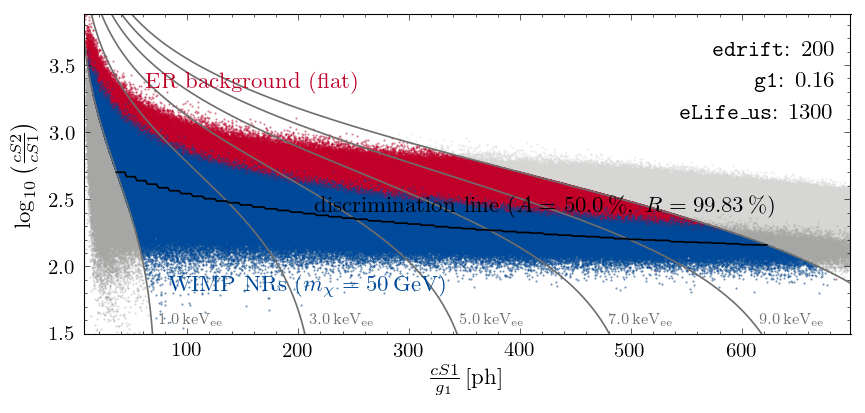

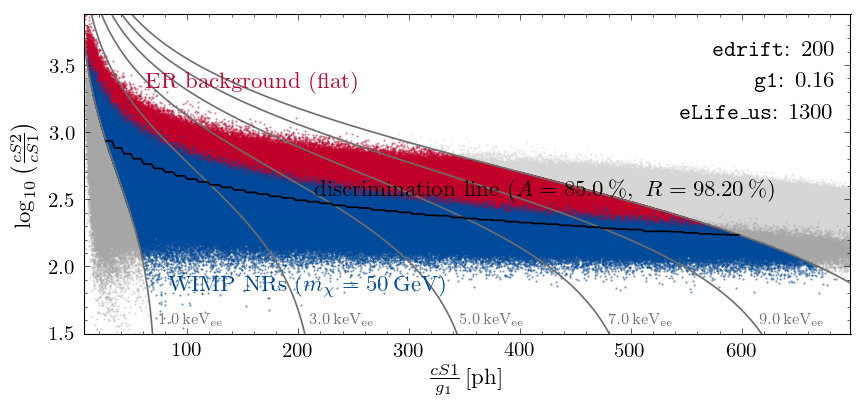

In [42]:

### pop analysis settings 

# energy bins
eroi = [1, 11] # in keV_ee
analysis_bin_edges = np.linspace(
    num = 50+1, # number of E_ee bins/slices
    start = eroi[0], # E_ee min
    stop = eroi[1], # E_ee max
    endpoint = True)
nr_acceptance_scan = [50, 85] # list of NR acceptances (in %) to be scanned

# formatting
observable_range = [0,500]
observable_range_number_of_bins = 50
observable_range_bin_edges = np.linspace(num=observable_range_number_of_bins, start=observable_range[0], stop=observable_range[1], endpoint=True)
leakage_fraction_percentile = 85 # e.g. 50: for an ER event to be considered 'leaking' it has to be 'lower' than 50 percent of the NR events within that bin.
threshold_events_per_bin = 60

# storage and naming
path_poplots = path_data +"poplots/"
path_popdata = path_data +"popdata/"
name_popdata = "popdata"
name_poplot = "poplot"

name_data_generation_for_presentation = "data_generation_for_presentation"

# debugging
ctr = 0
ctr_threshold = 0 # to restrict runtime


# setting up the 'summarized_data' ndarray
summarized_data_dtype_list = [("edrift", np.float64)]
for key, value in darwin_detector_parameter_space.items():
    summarized_data_dtype_list.append((key, np.float64))
summarized_data_dtype = np.dtype(summarized_data_dtype_list +[
    ("leakage_total", np.float64),
])
summarized_data_tuplelist = []




        
### pop analysis

flag_analysis_pop = True
if flag_analysis_pop == True:

    # looping over every ER/NR signature data pair and over every NR acceptance value
    for i in range(len(paramrange_edrift)):
        for key, val in parameter_sweep_dictionaries.items():
            if ctr <= ctr_threshold:

                # loading the signature data and cutting the events with negative S1 and S2 values
                er_data = np.load(path_signatures +name_simdata +"__" +filename_er_spectrum +str(paramrange_edrift[i]) +"__" +key +".npy")
                nr_data = np.load(path_signatures +name_simdata +"__" +filename_nr_spectrum +str(paramrange_edrift[i]) +"__" +key +".npy")
                er_data_cut = er_data[(er_data["s1_phe"] >= 0) & (er_data["s2_phe"] >= 0)]
                nr_data_cut = nr_data[(nr_data["s1_phe"] >= 0) & (nr_data["s2_phe"] >= 0)]

                # actual analysis: selecting sliced data and generating popdata, discrimination line and sliced data
                popdata_ndarray, nr_data_sliced, er_data_sliced = get_popdata_from_signature_data(
                    input_er_data = er_data_cut,
                    input_nr_data = nr_data_cut,
                    bin_edges = analysis_bin_edges,
                    threshold_events_per_bin = 20,
                    nr_acceptances = nr_acceptance_scan,
                    savestring = path_popdata +name_popdata +"__edrift_" +f"{paramrange_edrift[i]}_" +key +".npy",
                    flag_slicing = ["s1_g1", "er_ee"][1],
                    flag_returnsubdatasets = True,
                    **{
                        "g1" : parameter_sweep_dictionaries[key]["g1"],
                        "g2" : parameter_sweep_dictionaries[key]["g2_extracted"],
                        "w" : SF.W,
                    }
                )

                # generate one plot for every investigated nr acceptance
                for nracc in nr_acceptance_scan:
                    fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
                    ax1.set_xlim(observable_range)
                    x_lim = [np.min([min(er_data_sliced[i]["s1_phe"]) for i in range(len(er_data_sliced))])/parameter_sweep_dictionaries[key]["g1"], np.max([max(nr_data_sliced[i]["s1_phe"]) for i in range(len(nr_data_sliced))])/parameter_sweep_dictionaries[key]["g1"]]
                    y_lim = [np.min([np.min(nr_data_sliced[i]["log_s2_s1"]) for i in range(len(nr_data_sliced))]), np.max([np.max(er_data_sliced[i]["log_s2_s1"]) for i in range(len(er_data_sliced))])]
                    ax1.set_xlim(x_lim)
                    ax1.set_ylim(y_lim)
                    plt.xlabel(r"$\frac{cS1}{g_1}\,[\mathrm{ph}]$")
                    plt.ylabel(r"$\mathrm{log}_{10}\left(\frac{cS2}{cS1}\right)$")

                    # plotting excluded data
                    plt.scatter(
                        x = (1/parameter_sweep_dictionaries[key]["g1"])*er_data_cut["s1_phe"],
                        y = er_data_cut["log_s2_s1"],
                        s = 4,
                        facecolor = "#d6d6d4", # light light grey,
                        marker = ".",
                        alpha = 0.45,
                        linewidths = 0,
                        edgecolors = None)
                    plt.scatter(
                        x = (1/parameter_sweep_dictionaries[key]["g1"])*nr_data_cut["s1_phe"],
                        y = nr_data_cut["log_s2_s1"],
                        s = 4,
                        facecolor = "#a6a6a4", # light dark grey
                        marker = ".",
                        alpha = 0.45,
                        linewidths = 0,
                        edgecolors = None)

                    # plotting selected data
                    for j in range(len(er_data_sliced)): # plot er data first in order to avoid artifacts
                        plt.scatter(x=(1/parameter_sweep_dictionaries[key]["g1"])*er_data_sliced[j]["s1_phe"], y=er_data_sliced[j]["log_s2_s1"], s=4, facecolor=color_ers, marker=".", alpha=0.45, linewidths=0, edgecolors=None)
                    for j in range(len(er_data_sliced)):
                        plt.scatter(x=(1/parameter_sweep_dictionaries[key]["g1"])*nr_data_sliced[j]["s1_phe"], y=nr_data_sliced[j]["log_s2_s1"], s=4, facecolor=color_nrs, marker=".", alpha=0.45, linewidths=0, edgecolors=None)

                    # plotting energy contours
                    energy_contour_list = np.linspace(num=5+1, start=eroi[0], stop=eroi[1], endpoint=True)
                    for j in range(len(energy_contour_list)):
                        flag_printeval = True
                        if j == len(energy_contour_list)-1:
                            flag_printeval = False
                        draw_energy_contour_line(
                            param_e_keV = energy_contour_list[j], # in keV
                            param_g1 = parameter_sweep_dictionaries[key]["g1"],
                            param_g2 = parameter_sweep_dictionaries[key]["g2_extracted"],
                            param_w = SF.W,
                            number_of_samples = 150,
                            fmt_color = "#6e6e6d", ##8c8c8b",
                            fmt_rel_annotation_height_y = 0.04,
                            fmt_linewidth = 0.8,
                            fmt_fontsize = 7,
                            fmt_x_offset = 0.01,
                            flag_annotateenergyval = flag_printeval)

                    # plotting the discrimination line (via double list comprehension)
                    discrimination_line_data_x = [popdata_ndarray[j][i] for i in range(len(popdata_ndarray)) for j in ["nracc_" +f"{nracc:.1f}".replace(".","_") +"__" +"discriminationline_x_left", "nracc_" +f"{nracc:.1f}".replace(".","_") +"__" +"discriminationline_x_right"]]
                    discrimination_line_data_y = [popdata_ndarray[j][i] for i in range(len(popdata_ndarray)) for j in ["nracc_" +f"{nracc:.1f}".replace(".","_") +"__" +"threshold_value", "nracc_" +f"{nracc:.1f}".replace(".","_") +"__" +"threshold_value"]]
                    plt.plot(
                        discrimination_line_data_x,
                        discrimination_line_data_y,
                        color = "black",
                        linewidth = 0.8)

                    # printing annotations
                    plt.text( # er signature
                        x = 0.08,
                        y = 0.79,
                        transform = ax1.transAxes,
                        s = r"ER background (flat)",
                        color = color_ers,
                        fontsize = 11,
                        verticalalignment = 'center',
                        horizontalalignment='left')
                    plt.text( # wimp signature
                        x = 0.11,
                        y = 0.15,
                        transform = ax1.transAxes,
                        s = r"WIMP NRs ($m_{\chi}=" +f"{wimpmass}" +r"\,\mathrm{GeV}$)",
                        color = color_nrs,
                        fontsize = 11,
                        verticalalignment = 'center',
                        horizontalalignment = 'left')
                    parameter_vertical_linespacing = 0.1
                    parameter_pos_x = 0.98
                    parameter_pos_y = 0.89
                    parameter_pos_ctr = 1
                    plt.text( # drift field
                        x=parameter_pos_x,
                        y=parameter_pos_y,
                        transform=ax1.transAxes,
                        s = r"\texttt{edrift}: " +f"{paramrange_edrift[i]}",
                        color="black",
                        fontsize = 11,
                        verticalalignment='center',
                        horizontalalignment='right')
                    for k, v in parameter_sweep_dictionaries[key].items(): # other detector parameters
                        if k in key:
                            parameterstring = k.replace('_','\_')
                            plt.text(
                                x=parameter_pos_x,
                                y=parameter_pos_y -parameter_pos_ctr*parameter_vertical_linespacing,
                                transform=ax1.transAxes,
                                s = r"\texttt{" +f"{parameterstring}" +r"}: " +f"{v}",
                                color="black",
                                fontsize=11,
                                verticalalignment='center',
                                horizontalalignment='right')
                            parameter_pos_ctr += 1
                    total_rejection = calc_total_rejection_from_popdata( # calculating the toal rejection
                        input_popdata = popdata_ndarray,
                        nr_acceptance = nracc,
                        flag_definition = [
                            "total_number_of_ers_above_discrimination_line",
                            "number_of_ers_above_discrimination_line_weighted_by_nrs_in_bin"]
                            [0])
                    plt.text( # discrimination line
                        x = 0.30,
                        y = (discrimination_line_data_y[int(0.3*len(discrimination_line_data_x))]-y_lim[0])/(y_lim[1]-y_lim[0]) +0.02,
                        transform = ax1.transAxes,
                        s = r"discrimination line ($A=" +f"{(nracc):.1f}" +r"\,\%,\,\,R=" +f"{total_rejection:.2f}" +"\,\%$)",
                        color="black",
                        fontsize=11,
                        verticalalignment='center',
                        horizontalalignment='left')
                    #plt.legend()

                    # saving the plot
                    savestring = "__edrift_" +f"{paramrange_edrift[i]}"
                    for k, v in val.items():
                        if k in key:
                            savestring = savestring +"_" +k +"_" +str(v).replace(".","_")
                    savestring = savestring +"__" +"nracc_" +f"{nracc:.1f}".replace(".","_")
                    fig.savefig(path_poplots +name_poplot +"__" +savestring +".png")
                    ctr += 1

                    # plotting for presentations
                    if (paramrange_edrift[i] == 100) and (key == "g1_0_25_eLife_us_1000"):
                        fig.savefig(path_output_presentationstuff +name_presentation +"__" +name_poplot +".png")
                        fig.savefig(path_presentation +name_presentation +"__" +name_poplot +".png")

    ### saving the 'summarized_data' ndarray
    summarized_data_ndarray = np.array(summarized_data_tuplelist, summarized_data_dtype)
    np.save(path_data +name_summarized_data +".npy", summarized_data_ndarray)


## 4.2 Comparing Populations

This cell is meant to generate a dictionary (`cumulative_investigation_dictionary`) of the following form:

<code>
    cumulative_investigation_dictionary = {

        `investigation_parameter_1` : {
        
            `constant_parameter_string_1_1` : [
                `filename_1`,
                `filename_2`,
                `filename_3`,
                `filename_4`,
                `filename_5`,
                `filename_6`,
                `filename_7`
            ], 
            
            `constant_parameter_string_1_2` : [
                ...
            ]
        },

        `investigation_parameter_2` : {
            ...
        },

        ...
    
    }
<code>


In the further work of this section this dictionary will be used to loop over and to generate plots for each collection of filenames.


### defining a dictionary containing all parameters to be looped over (i.e. inc. 'edrift')
parameter_dictionary = darwin_detector_parameter_space.copy()
parameter_dictionary.update({"edrift" : paramrange_edrift})

### defining the output 'cumulative_investigation_dictionary'
cumulative_investigation_dictionary = parameter_dictionary.copy()
for key, val in cumulative_investigation_dictionary.items():
    cumulative_investigation_dictionary[key] = {}

### looping over all 'investigation_parameter's and and generating the 'cartesian_list'
### containing every possible combination of static parameter values for this specific 'investigation_parameter'
for investigation_parameter in ["edrift"] +[*darwin_detector_parameter_space]:
    # generating a dictionary containing all keys but the current 'investigation_parameter'
    parameter_dictionary_without_investigation_parameter = parameter_dictionary.copy()
    parameter_dictionary_without_investigation_parameter.pop(investigation_parameter)
    # generating 'cartesian_list'
    cartesian_list = {}
    for key in parameter_dictionary_without_investigation_parameter.keys():
        cartesian_list.update({key:[]})
        for i in range(len(parameter_dictionary_without_investigation_parameter[key])):
            cartesian_list[key].append([key, parameter_dictionary_without_investigation_parameter[key][i]])
    parameters_cartesian_product = list(itertools.product(*cartesian_list.values()))
    cartesian_list = []
    for i in range(len(parameters_cartesian_product)):
        append_dict = {}
        for j in range(len(parameters_cartesian_product[i])):
            append_dict.update({parameters_cartesian_product[i][j][0] : parameters_cartesian_product[i][j][1]})
        cartesian_list.append(append_dict)

    ### printing cartesian list
    #print(investigation_parameter)
    #for i in range(len(cartesian_list)):
    #    for key, val in cartesian_list[i].items():
    #        print(key, val)
    #print("\n\n\n")

    ### looping over all detector configurations within 'cartesian_list' and filling the 'cumulative_investigation_dictionary'
    for i in range(len(cartesian_list)):

        # adding the current 'constant_parameter_string' to the 'cumulative_investigation_dictionary[investigation_parameter]'
        constant_parameter_string = ""
        for key, val in cartesian_list[i].items():
            constant_parameter_string = constant_parameter_string +key +"_" +str(val).replace(".","_") +"_"
        if constant_parameter_string.endswith("_"):
            constant_parameter_string = constant_parameter_string[:-1]
        cumulative_investigation_dictionary[investigation_parameter].update({constant_parameter_string : []})

        # adding all the corresponding filenames (i.e. all files matching the 'constant_parameter_string' but differing in 'investigation_parameter')
        # to 'cumulative_investigation_dictionary[investigation_parameter][constant_parameter_string]'
        # by looping over the variable parameter values (i.e. the values of 'investigation_parameter')
        for j in range(len(parameter_dictionary[investigation_parameter])):

            # constructing the filename from 'cartesian_list'
            filename = name_popdata +"__edrift_"
            if investigation_parameter == "edrift":
                filename = filename +str(parameter_dictionary[investigation_parameter][j]).replace(".", "_")
            else:
                filename = filename +str(cartesian_list[i]["edrift"]).replace(".", "_")
            param_val_dict = cartesian_list[i].copy()
            param_val_dict.update({investigation_parameter : parameter_dictionary[investigation_parameter][j]})
            if "edrift" in [*param_val_dict]:
                param_val_dict.pop("edrift")
            for k in sorted([*param_val_dict]):
                filename = filename +"_" +k +"_" +str(param_val_dict[k]).replace(".","_")
            if filename.endswith("_"):
                filename = filename[:-1]
            filename = filename +".npy"
            cumulative_investigation_dictionary[investigation_parameter][constant_parameter_string].append(filename)

# printing the final 'cumulative_investigation_dictionary'
print(f"\n This is the 'cumulative_investigation_dictionary':\n\n\n")
for key, val in cumulative_investigation_dictionary.items():
    print(f"investigation_parameter: {key}\n")
    for k, v in cumulative_investigation_dictionary[key].items():
        print("\t", k)
        for i in range(len(cumulative_investigation_dictionary[key][k])):
            if os.path.isfile(path_popdata +cumulative_investigation_dictionary[key][k][i]):
                foundstring = ""
            else:
                foundstring = "<---- not found"
            print("\t\t", cumulative_investigation_dictionary[key][k][i], foundstring)
        print("")
    print("\n\n\n")

The cell below is used to loop over the 'cumulative_investigation_dictionary' in order to load the associated 'popdata' and generate the 'complots' from it.


name_complots = "complot"
path_output_complots = path_output +"complots/"
ctr = 0
ctr_threshold = 10**6


def variable_mamba_like_color_palette(n, i):
    color_dict = {
        "1" : [
            "cyan",
        ],
        "2" : [
            "#fb0098",
            "#001eff",
        ],
        "3" : [
            "#fb0098",
            "#c800fd",
            "#001eff",
        ],
        "4" : [
            "#fb0098",
            "#f000ff",
            "#8900ff",
            "#001eff",
        ],
        "5" : [
            "#fb0098",
            "#f000ff",
            "#c800fd",
            "#8900ff",
            "#001eff",
        ],
    }
    if str(n) not in [*color_dict]:
        raise Exception("too many parameters to check")
    else:
        return color_dict[str(n)][i]


color_complot_list = [ # mamba color palette: https://www.color-hex.com/color-palette/93012
    "#fb0098",
    "#f000ff",
    "#c800fd",
    "#8900ff",
    "#001eff",
]
markerstyle_list = [
    "o",
    "^",
    "s",
    "P",
    "D",
    "H",
    "*",
]

flag_analysis_comparative = True
if flag_analysis_comparative == True:


    ### looping over the 'cumulative_investigation_dictionary'
    for key, val in cumulative_investigation_dictionary.items():
        for k, v in cumulative_investigation_dictionary[key].items():

            # installing a counter to prevent too long compiling times
            if ctr < ctr_threshold:

                ### loading the poplot data
                data_list = []
                for i in range(len(cumulative_investigation_dictionary[key][k])):
                    data_list.append(np.load(path_popdata +cumulative_investigation_dictionary[key][k][i]))

                ### plotting
                # formatting
                fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
                ax1.set_xlim(observable_range)
                plt.yscale("log")
                plt.xlabel(r"$\frac{cS1}{g_1}\,[\mathrm{ph}]$")
                plt.ylabel(r"binned leakage fraction $l_{\mathrm{bin}}^{" +f"{leakage_fraction_percentile/100:.2f}" +"}$")
                # plotting data
                for i in range(len(data_list)):
                    plt.errorbar(
                        marker="", # plotting just the errorbars
                        linestyle="",
                        fmt='',
                        x=data_list[i]["bin_center"],
                        y=data_list[i]["leakage_fraction_in_bin"],
                        yerr=np.multiply(data_list[i]["leakage_fraction_in_bin_error"], 1), # scaling the errors for visibility reasons
                        xerr=0.5*(data_list[i]["bin_center"][1]-data_list[i]["bin_center"][0]),
                        ecolor=variable_mamba_like_color_palette(n=len(data_list), i=i),
                        elinewidth=0.5,
                        capsize=1.2,
                        barsabove=True,
                        capthick=0.5
                    )
                labelstring_dict = {
                    "edrift" : [r"$E_{\mathrm{drift}}$", r"$\mathrm{\frac{V}{cm}}$"],
                    "g1" : [r"$g_1$", r""],
                    "eLife_us" : [r"$\tau_{e}$", r"$\mu \mathrm{s}$"],
                }
                for i in range(len(data_list)):
                    plt.plot(
                        data_list[i]["bin_center"],
                        data_list[i]["leakage_fraction_in_bin"],
                        marker=markerstyle_list[i%len(markerstyle_list)],
                        linestyle="",
                        markersize=3.8,
                        markerfacecolor="white",
                        alpha=1,
                        markeredgewidth=0.5,
                        markeredgecolor=variable_mamba_like_color_palette(n=len(data_list), i=i),
                        label = labelstring_dict[key][0] +r"$=$" +f"{parameter_dictionary[key][i]}" +"$\,$" +labelstring_dict[key][1]
                    )
                # annotations
                parameter_vertical_linespacing = 0.1
                parameter_pos_x = 0.035
                parameter_pos_y = 0.91
                parameter_pos_ctr = 0
                for qey in sorted([*default_detector_parameters] +["edrift"]):
                    if qey in k:
                        print(qey)
                        parameterstring = qey.replace('_','\_')
                        parametervalue = SF_process.get_parameter_val_from_filename(filename=k, parametername=qey)
                        plt.text(x=parameter_pos_x, y=parameter_pos_y -parameter_pos_ctr*parameter_vertical_linespacing, transform=ax1.transAxes, s=r"\texttt{" +f"{parameterstring}" +r"}: " +f"{parametervalue}", color="black", fontsize=11, verticalalignment='center', horizontalalignment='left')
                        parameter_pos_ctr += 1
                # legend
                plt.legend()
                # saving
                savename = "complot__" +key +"__" +k
                fig.savefig(path_output_complots +savename +".png")

                # increasing the counter
                ctr += 1
                
                ### plotting for presentations
                if ((key == "edrift") and (k == "g1_0_25_eLife_us_500")) or ((key == "g1") and (k == "eLife_us_1000_edrift_500")) or ((key == "eLife_us") and (k == "g1_0_11_edrift_100")):
                    fig.savefig(path_output_presentationstuff +name_presentation +"__" +name_complot +"_" +key +".png")
                    fig.savefig(path_presentation +name_presentation +"__" +name_complot +"_" +key +".png")


# Testing